# Assignment 4 - Vanilla RNN

## Libraries

In [1]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import trange

In [2]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data

In [3]:
book_fname = 'data/goblet_book.txt'
with open(book_fname, 'r') as f:
    book_data = f.read()
    f.close()

book_chars = list(set(book_data))
K = len(book_chars)
print(f"Number of unique characters: {K}")
char2ind, ind2char = dict(), dict()
for i, c in enumerate(book_chars):
    char2ind[c] = i
    ind2char[i] = c

Number of unique characters: 80


## Model

In [4]:
class RNN:

    def __init__(self, m=100, seq_length=25, eta=.001, gamma=.9, sig=.01, device=device):
        self.m = m
        self.seq_length = seq_length
        self.eta = eta
        self.gamma = gamma
        self.device = device

        self.V = torch.randn(K, m).to(self.device) * sig
        self.c = torch.zeros(K, 1).to(self.device)
        self.W = torch.randn(m, m).to(self.device) * sig
        self.b = torch.zeros(m, 1).to(self.device)
        self.U = torch.randn(m, K).to(self.device) * sig

        self.V_g_ada = torch.zeros(K, m).to(self.device)
        self.c_g_ada = torch.zeros(K, 1).to(self.device)
        self.W_g_ada = torch.zeros(m, m).to(self.device)
        self.b_g_ada = torch.zeros(m, 1).to(self.device)
        self.U_g_ada = torch.zeros(m, K).to(self.device)

        self.V_best = self.V.clone()
        self.c_best = self.c.clone()
        self.W_best = self.W.clone()
        self.b_best = self.b.clone()
        self.U_best = self.U.clone()

        self.smooth_losses = list()

        self.grads = {
            'V': torch.zeros_like(self.V),
            'c': torch.zeros_like(self.c),
            'W': torch.zeros_like(self.W),
            'b': torch.zeros_like(self.b),
            'U': torch.zeros_like(self.U)
        }

    def synthesize(self, h_prev, x, n, best=False):
        Y = torch.zeros((K, n)).to(self.device)
        x_t = x
        for i in range(n):
            h_prev, p = self.forward(h_prev, x_t, best=best)
            cp = torch.cumsum(p, dim=0)
            r = torch.rand(1)
            for j in range(K):
                if r < cp[j]:
                    break
            Y[j, i] = 1
            x_t = torch.zeros((K, 1))
            x_t[j] = 1
        return Y

    def forward(self, h_prev, x, best=False):
        if not best:
            h = torch.tanh(self.W @ h_prev + self.U @ x + self.b)
            y = self.V @ h + self.c
            p = torch.softmax(y, dim=0)
        else:
            h = torch.tanh(self.W_best @ h_prev + self.U_best @ x + self.b_best)
            y = self.V_best @ h + self.c_best
            p = torch.softmax(y, dim=0)
        return h, p
    
    def forward_pass(self, h_0, X, Y, best=False):
        h = h_0
        H = torch.zeros((self.m, self.seq_length + 1)).to(self.device)
        P = torch.zeros((K, self.seq_length)).to(self.device)
        H[:, 0] = h.flatten()
        loss = 0
        for i in range(self.seq_length):
            h, p = self.forward(h, X[:, i].reshape(K, 1), best=best)
            H[:, i+1] = h.flatten()
            P[:, i] = p.flatten()
            loss += self.loss(p, Y[:, i].reshape(K, 1))
        return H, P, loss

    def backward_pass(self, H, P, X, Y):
        self.grads = {
            'V': torch.zeros_like(self.V),
            'c': torch.zeros_like(self.c),
            'W': torch.zeros_like(self.W),
            'b': torch.zeros_like(self.b),
            'U': torch.zeros_like(self.U)
        }
        dL_dh_next = torch.zeros((self.m, 1)).to(self.device)
        h0 = H[:, 0].reshape(self.m, 1)
        H = H[:, 1:]
        for i in range(self.seq_length-1, -1, -1):
            x = X[:, i].reshape(K, 1)
            y = Y[:, i].reshape(K, 1)
            h = H[:, i].reshape(self.m, 1)
            p = P[:, i].reshape(K, 1)
            g = (p - y).T
            self.grads['V'] += g.T @ h.T
            self.grads['c'] += g.T
            dL_dh = self.V.T @ g.T + self.W.T @ dL_dh_next
            dL_dh_next = dL_dh * (1 - h ** 2)
            self.grads['W'] += dL_dh_next @ H[:, i-1].reshape(1, self.m) if i != 0 else dL_dh_next @ h0.T
            self.grads['b'] += dL_dh_next
            self.grads['U'] += dL_dh_next @ x.T
    
    def update_params(self, eps=1e-8):
        for key in self.grads.keys():
            self.grads[key] = torch.clamp(self.grads[key], -5, 5)
            vars(self)[key + '_g_ada'] = self.gamma * vars(self)[key + '_g_ada'] + (1 - self.gamma) * self.grads[key] ** 2
            vars(self)[key] -= self.eta * self.grads[key] / torch.sqrt(vars(self)[key + '_g_ada'] + eps)


    def loss(self, p, y):
        return - torch.sum(y.T @ torch.log(p))

    def train(self, book_data, n_epochs=10):
        n_iter = 0
        smooth_loss = 0
        best_loss = torch.inf
        pbar = trange(n_epochs)
        for epoch in pbar:
            pbar.set_description(f"Epoch {epoch}/{n_epochs}")
            self.e = 0
            h = torch.zeros((self.m, 1)).to(self.device)
            while self.e + self.seq_length <= len(book_data):
                X_chars = book_data[self.e:self.e+self.seq_length]
                Y_chars = book_data[self.e+1:self.e+self.seq_length+1]
                X = torch.zeros((K, self.seq_length)).to(self.device)
                Y = torch.zeros((K, self.seq_length)).to(self.device)
                for i in range(self.seq_length):
                    X[char2ind[X_chars[i]], i] = 1
                    Y[char2ind[Y_chars[i]], i] = 1

                H, P, loss = self.forward_pass(h, X, Y)
                self.backward_pass(H, P, X, Y)
                self.update_params()

                smooth_loss = .999 * smooth_loss + .001 * loss if smooth_loss != 0 else loss
                self.smooth_losses.append(smooth_loss)

                if smooth_loss < best_loss:
                    best_loss = smooth_loss
                    self.V_best = self.V.clone()
                    self.c_best = self.c.clone()
                    self.W_best = self.W.clone()
                    self.b_best = self.b.clone()
                    self.U_best = self.U.clone()

                h = H[:, -1].reshape(self.m, 1)

                n_iter += 1
                if n_iter % 1000 == 0:
                    print(
                        f"Training - Iteration {n_iter} - Loss {smooth_loss}")
                    
                if n_iter % 10000 == 0:
                    Y = self.synthesize(h, X[:, 0].reshape(K, 1), 200)
                    print()
                    print(''.join([ind2char[torch.argmax(Y[:, i]).item()] for i in range(200)]))
                    print()

                self.e += self.seq_length

        print(f"Training done - Best loss: {best_loss}")

    def check_grads(self, book_data):
        for key in self.grads.keys():
            vars(self)[key].requires_grad = True

        X_chars = book_data[:self.seq_length]
        Y_chars = book_data[1:self.seq_length+1]
        X = torch.zeros((K, self.seq_length)).to(self.device)
        Y = torch.zeros((K, self.seq_length)).to(self.device)
        h0 = torch.zeros((self.m, 1)).to(self.device)
        for i in range(self.seq_length):
            X[char2ind[X_chars[i]], i] = 1
            Y[char2ind[Y_chars[i]], i] = 1

        H, P, loss = self.forward_pass(h0, X, Y)
        self.backward_pass(H, P, X, Y)

        for key in self.grads.keys():
            vars(self)[key].retain_grad()
        loss.backward()

        print("Checking gradients")
        with torch.no_grad():
            for key in self.grads.keys():
                diff = torch.norm(self.grads[key] - vars(self)[key].grad)
                rel_err = diff / (torch.norm(self.grads[key]) + torch.norm(vars(self)[key].grad) + 1e-16)
                print(f"Relative error on {key}: {rel_err}")

    def plot_losses(self):
        plt.plot(self.smooth_losses)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Smoothed loss')
        plt.show()

In [5]:
rnn = RNN()
rnn.check_grads(book_data)

Checking gradients
Relative error on V: 2.5516257551316812e-08
Relative error on c: 3.1791032029104827e-08
Relative error on W: 4.424012800541277e-08
Relative error on b: 3.4715078811586864e-08
Relative error on U: 3.0388012106641327e-08


In [6]:
rnn = RNN()
rnn.train(book_data, n_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Training - Iteration 1000 - Loss 84.24075317382812
Training - Iteration 2000 - Loss 70.29157257080078
Training - Iteration 3000 - Loss 63.131553649902344
Training - Iteration 4000 - Loss 60.006046295166016
Training - Iteration 5000 - Loss 58.24372482299805
Training - Iteration 6000 - Loss 57.70429611206055
Training - Iteration 7000 - Loss 57.407562255859375
Training - Iteration 8000 - Loss 55.144195556640625
Training - Iteration 9000 - Loss 54.24985885620117
Training - Iteration 10000 - Loss 53.96211624145508

and this cound aile lenre, ntee afri, paryut-t unintey, Herpiingn enom. MRd her, ad ugmmelle way toup. Headd,y's vin sarm as dinged late gicitt you "u biono the mers to as blour to Ron l ont oond a'd 

Training - Iteration 11000 - Loss 54.546627044677734
Training - Iteration 12000 - Loss 53.84162139892578
Training - Iteration 13000 - Loss 53.02122497558594
Training - Iteration 14000 - Loss 52.165767669677734
Training - Iteration 15000 - Loss 52.1815185546875
Training - Iteration 

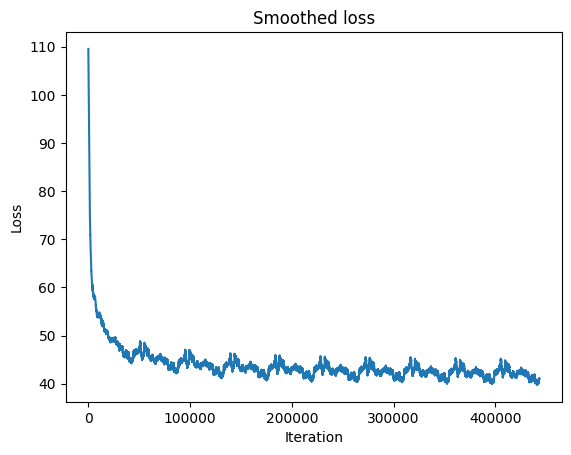

In [7]:
rnn.plot_losses()

In [8]:
starting_char = 'H'
X = torch.zeros((K, 1)).to(device)
X[char2ind[starting_char], 0] = 1
h = torch.zeros((rnn.m, 1)).to(device)
Y = rnn.synthesize(h, X, 1000, best=True)
print(starting_char + ''.join([ind2char[torch.argmax(Y[:, i]).item()] for i in range(1000)]))

Haired.
"one eher.
ark Harry at Harry you a she seemed, as in eyely wa lear . . . tak essey "Iband of it was botter mament.  Harry, hisn't ebored over to pling to Harry meas scar and evening foum rour, back.  Harry loured of echa nead, Harryes," said Dumbledore spron Head a rueared with to himse, he was bbeast into to wit slight, sleco have serpt of the beoind not to all and see hand to it once cound.n as . .  he had deal let reared. . . as, look a monever," he koitied it," sait making it ever deano eocore though at necause coutintry is finct perient complets at he said you wished in with eyes,  ons snaving it if the feck nose very flit you'd needs wvery comple to returned misting him noins, anman," said Dumbledore hurr ,"rever armost for under no you now.  Iy arwived a with hop eearclessaining to me hi" reaked the Hisped, hush have sparmally for it as" grappus coul must for a nooked to me a see of him, now my moutinting rest ofhed, pece to festared ut thi"
"you oid, and the wanded ahe